In [77]:
%matplotlib ipympl

In [2]:
import sys
import os
import matplotlib.pyplot as plt
import geopandas as gpd
sys.path.append('..')
from rasterio.mask import mask
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from h3_helper import *
import seaborn as sns
import fiona
import pysal.viz.mapclassify as mc
from libpysal.weights.contiguity import Queen

### Elevation

In [53]:
elevation_raster = os.path.dirname(os.getcwd()) + r"/data/eesti_clipped/small_extent/MeritDEM90m.tif"

In [54]:
h3_el_10 = raster_to_h3(elevation_raster, 'elevation', 8, 11, None, 1)

Raster pixel size 92.6624388709314
10
Start filling raster extent with h3 indexes at resolution 10
Start getting raster values for hexes at resolution 10


In [32]:
h3_el_10

,cell_id,elevation
0,8a11361964a7fff,104.144875
5,8a11350a5587fff,0.000000
8,8a1130b445b7fff,74.368828
9,8a1f658b6987fff,11.231266
10,8a1135833977fff,0.000000
...,...,...
13047580,8a089a6ac18ffff,23.684309
13047582,8a1f65224997fff,75.676384
13047584,8a089e520ba7fff,0.000000
13047585,8a089b7662b7fff,0.000000


In [55]:
h3_el_8 = cell_h3_downsampling(h3_el_10,'cell_id','elevation',8,'numeric')

### Population

In [56]:
population = r"d:\UTCloud\DGGS\data\EestiClipped\population\est_ppp_2020_1km_Aggregated.tif"

In [57]:
h3_pop_8 = raster_to_h3(population, 'population', 8, 11, None, 2)

Raster pixel size 926.624384998697
8
Start filling raster extent with h3 indexes at resolution 8
Start getting raster values for hexes at resolution 8


### Precipitation

In [58]:
percipitation = r'd:\UTCloud\DGGS\data\EestiClipped\climate\precipitation\precipitationAnnual.tif'

In [59]:
h3_percip_8 = raster_to_h3(percipitation, 'percipitation', 8, 11, None, 2)

Raster pixel size 926.624384998697
8
Start filling raster extent with h3 indexes at resolution 8
Start getting raster values for hexes at resolution 8


### Temperature

In [34]:
full_raster = rasterio.open(r'd:\UTCloud\DGGS\data\temperature\CHELSA_temp10_01_1979-2013_V1.2_land.tif')

In [36]:
fiona.listlayers(r'd:\UTCloud\DGGS\data\EestiClipped\shapes\extent.gpkg')

['extent_min']

In [37]:
clip_mask = gpd.read_file(r'd:\UTCloud\DGGS\data\EestiClipped\shapes\extent.gpkg', layer='extent_min')

In [38]:
out_image, out_transform = mask(dataset=full_raster, shapes=clip_mask['geometry'], crop=True)

In [39]:
out_meta = full_raster.meta.copy()

In [40]:
out_meta.update({"driver": "GTiff","height": out_image.shape[1],"width": out_image.shape[2],"transform": out_transform})

In [41]:
with rasterio.open(r'd:\UTCloud\DGGS\data\EestiClipped\climate\temperature\january_mean_temp.tif', "w", **out_meta) as dest:
    dest.write(out_image)

In [263]:
clipped_raster = rasterio.open(os.path.dirname(os.getcwd()) + r"/data/eesti_clipped/small_extent/MeritDEM90m_clipped.tif")

In [60]:
temperature = r'd:\UTCloud\DGGS\data\EestiClipped\climate\temperature\january_mean_temp.tif'

In [61]:
h3_temp_8 = raster_to_h3(temperature, 'temperature', 8, 11, None, 2)

Raster pixel size 926.6243849972824
8
Start filling raster extent with h3 indexes at resolution 8
Start getting raster values for hexes at resolution 8


### Corine

In [62]:
corine = os.path.dirname(os.getcwd()) + r'\data\eesti_clipped\land_cover\CorineEestiWGS84.gpkg'

In [63]:
h3_cor_10 = vector_to_h3(corine,'code_18',10)

Start filling raster extent with h3 indexes at resolution 10


In [64]:
h3_cor_8 = cell_h3_downsampling(h3_cor_10,'cell_id','code_18',8,'categorical')

### Soils

In [46]:
soils = r'd:\UTCloud\DGGS\data\soils\Mullakaart.gpkg'

In [47]:
h3_soils_10 = vector_to_h3(soils,'Varv',10)

Start filling raster extent with h3 indexes at resolution 10


In [50]:
del(h3_soils_10)

In [49]:
h3_soils_8 = cell_h3_downsampling(h3_soils_10,'cell_id','Varv',8,'categorical')

In [ ]:
h3_soils_8

In [45]:
soils.to_crs('EPSG:4326').to_file(r'd:\UTCloud\DGGS\data\soils\Mullakaart.gpkg',layer='soils',driver='GPKG')

### Merging everything together

In [65]:
h3_el_8.merge(h3_cor_8,how='left').merge(h3_temp_8,how='left').merge(h3_percip_8,how='left').merge(h3_pop_8,how='left').fillna(0).merge(h3_soils_8,how='left').to_csv(r'd:\UTCloud\DGGS\results\aggregation_example\h3_agg.csv',index=False)

In [141]:
len(h3_eesti)

124767

In [3]:
h3_eesti = pd.read_csv(r'd:\UTCloud\DGGS\results\aggregation_example\h3_agg.csv')

In [138]:
example = h3_eesti[(h3_eesti['elevation']>0)&(h3_eesti['Varv']>0)].sample(10)

In [139]:
example.columns = ['cell_id','elevation','land_cover','temperature','precipitation','population','soils']

In [140]:
example.to_csv(r'd:\UTCloud\DGGS\results\aggregation_example\example_table.csv', index=False)

In [149]:
h3_eesti = h3_eesti.rename(columns={'percipitation':'precipitation'})

In [148]:
h3_eesti

,cell_id,elevation,code_18,temperature,percipitation,population,Varv
0,8808932091fffff,0.000000,523,0.0,0.0,0.000000,21.0
1,8808932093fffff,0.000000,523,0.0,0.0,0.000000,21.0
2,8808932095fffff,0.000000,523,0.0,0.0,0.000000,21.0
3,8808932097fffff,0.000000,523,0.0,0.0,0.000000,21.0
4,8808932099fffff,0.000000,523,0.0,0.0,0.000000,21.0
...,...,...,...,...,...,...,...
124762,881f6c9365fffff,167.011547,312,-55.0,632.0,0.000000,5.0
124763,881f6c9367fffff,163.201012,311,-54.0,625.0,0.000000,5.0
124764,881f6c9369fffff,162.002986,311,-54.0,627.0,0.027659,1.0
124765,881f6c936bfffff,160.834662,243,-54.0,626.0,0.000000,6.0


In [153]:
fig, ax = plt.subplots(figsize=(10,5))
sns.regplot(data=h3_eesti[h3_eesti['precipitation']>0],x='elevation', y='precipitation', ax=ax,scatter_kws={"s": 10},line_kws={'color':'r'})
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Elevation', fontsize=12)
ax.set_ylabel('Precipitation', fontsize=12)
#ax.set_title('Relation between elevation and precipitation', fontsize=14)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\aggregation_example\scatterplot.png', bbox_inches="tight",dpi=300)

C:\Users\Iam\Anaconda3\envs\dggs\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [71]:
intervals = mc.EqualInterval(h3_eesti['elevation'],10)

In [72]:
h3_eesti['elevation_classes'] = h3_eesti[['elevation']].apply(intervals)

In [123]:
fig, ax = plt.subplots(figsize=(10,5))
h3_eesti.groupby('elevation_classes')['population'].sum().plot(kind='bar',ax=ax)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Elevation, m', fontsize=12)
ax.set_ylabel('Population', fontsize=12)
ax.set_xticklabels(intervals.get_legend_classes(), fontsize=10)
ax.set_title('', fontsize=14)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\aggregation_example\elevation_population.png', bbox_inches="tight",dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [4]:
h3_eesti = create_h3_geometry(h3_eesti)

In [6]:
h3_eesti.to_file(r'd:\UTCloud\DGGS\results\aggregation_example\example_table.geojson',driver='GeoJSON')

<AxesSubplot:>

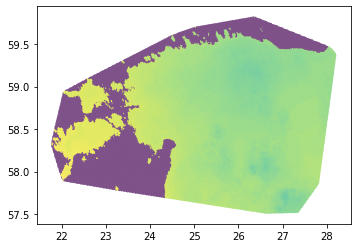

In [8]:
h3_eesti.plot(column='temperature')